In [230]:
# ! pip install pandas numpy matplotlib seaborn  scikit-learn pyod

## Import Libraries

In [231]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from sklearn.preprocessing import RobustScaler
from pyod.models.knn import KNN
from sklearn.impute import SimpleImputer


## Load data

In [232]:
df = pd.read_csv('churn_data.csv')
df.describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7032.000000
mean     32.371149       64.761692   2283.300441
std      24.559481       30.090047   2266.771362
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3794.737500
max      72.000000      118.750000   8684.800000

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   PhoneService    7043 non-null   object 
 3   Contract        7043 non-null   object 
 4   PaymentMethod   7043 non-null   object 
 5   MonthlyCharges  7043 non-null   float64
 6   TotalCharges    7032 non-null   float64
 7   Churn           7043 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 440.3+ KB


## Data filtering

In [234]:
df['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [235]:
churn_df = df[df['Churn'] == 'No']
unique_churn_values = churn_df['Churn'].unique()
unique_churn_values

array(['No'], dtype=object)

In [236]:
# Filter the churn dataset for customers with MonthlyCharges greater than a 80
high_monthly_charges_df = df[df['MonthlyCharges'] > 80]
high_monthly_charges_df.head()


customerID  tenure PhoneService        Contract  \
5   9305-CDSKC       8          Yes  Month-to-month   
6   1452-KIOVK      22          Yes  Month-to-month   
8   7892-POOKP      28          Yes  Month-to-month   
12  8091-TTVAX      58          Yes        One year   
13  0280-XJGEX      49          Yes  Month-to-month   

                PaymentMethod  MonthlyCharges  TotalCharges Churn  
5            Electronic check           99.65        820.50   Yes  
6     Credit card (automatic)           89.10       1949.40    No  
8            Electronic check          104.80       3046.05   Yes  
12    Credit card (automatic)          100.35       5681.10    No  
13  Bank transfer (automatic)          103.70       5036.30   Yes

## Check for outliers

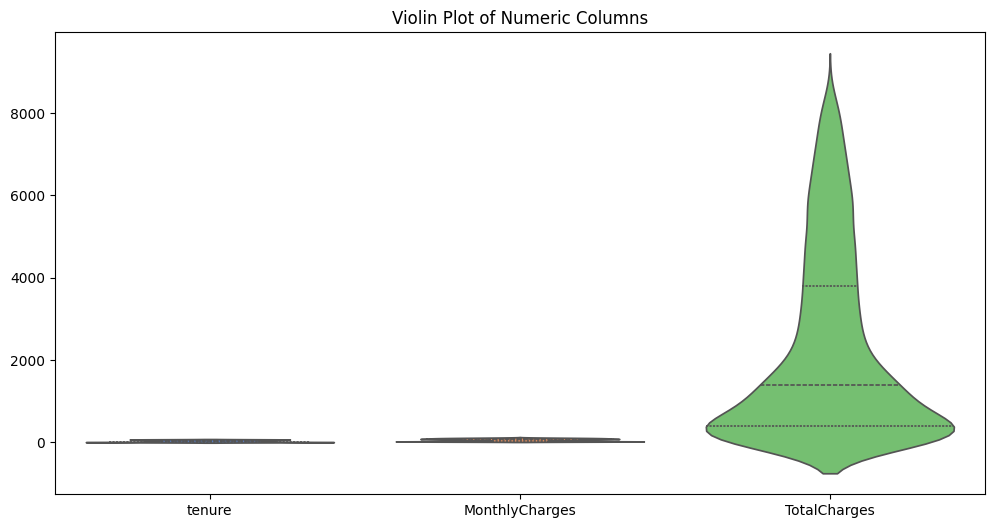

In [237]:

numeric_columns = df.select_dtypes(include=np.number).columns

# violin plot for numeric columns
plt.figure(figsize=(12, 6))
sns.violinplot(data=df[numeric_columns], inner="quartile", palette="muted")
plt.title("Violin Plot of Numeric Columns")
plt.show()

## Clipping outliers

In [238]:

for column in numeric_columns:
    # Calculate IQR
    column_iqr = iqr(df[column])
    
    # Set upper and lower boundaries
    upper_boundary = df[column].quantile(0.75) + 1.5 * column_iqr
    lower_boundary = df[column].quantile(0.25) - 1.5 * column_iqr
    
    # Clip values outside the boundaries
    df[column] = df[column].clip(lower=lower_boundary, upper=upper_boundary)
    
    


## Check missing values

In [239]:
df.isna().sum()

customerID         0
tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

In [240]:
# Infer objects before interpolation
df = df.infer_objects()
df.interpolate(method='linear', inplace=True)

/tmp/ipykernel_18253/2460190539.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [241]:
df.dropna(inplace=True)

## Convert Categorical columns to numeric

In [242]:
df['PhoneService'] = df['PhoneService'].replace({'No': 0, 'Yes': 1})
df['PhoneService'].value_counts()

PhoneService
1    6361
0     682
Name: count, dtype: int64

In [243]:
df['Contract'] = df['Contract'].replace({'Month-to-month': 0, 'One year': 1, 'Two year' : 3})
df['Contract'].value_counts()

Contract
0    3875
3    1695
1    1473
Name: count, dtype: int64

In [244]:
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   PhoneService    7043 non-null   int64  
 3   Contract        7043 non-null   int64  
 4   PaymentMethod   7043 non-null   object 
 5   MonthlyCharges  7043 non-null   float64
 6   TotalCharges    7043 non-null   float64
 7   Churn           7043 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 440.3+ KB


# Feature Engineering

In [246]:
df_copy = df.copy()
df_copy['TotalCharges'] = np.log(df_copy['TotalCharges'])

<Axes: ylabel='Frequency'>

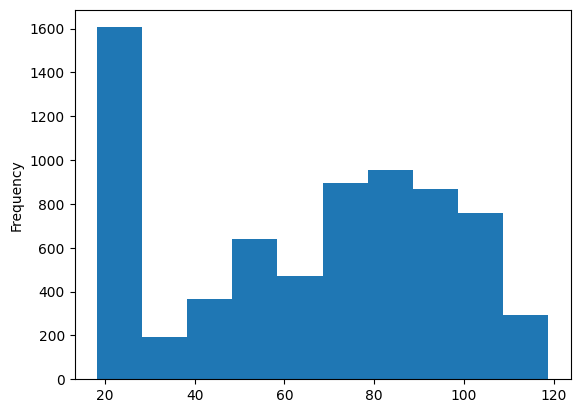

In [247]:
df_copy['MonthlyCharges'].plot.hist()

## New Features

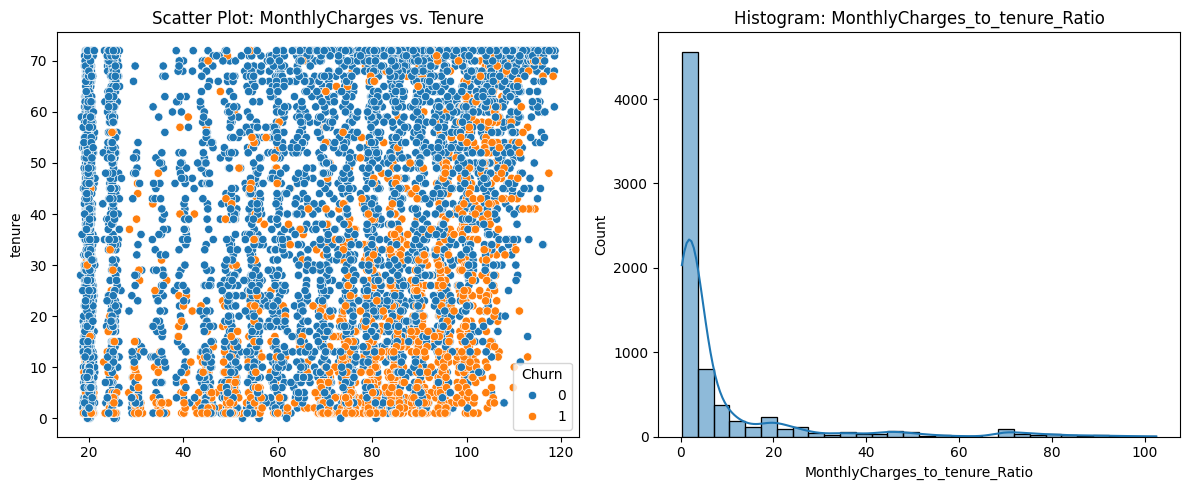

In [248]:
#  Ratio of MonthlyCharges to tenure
df['MonthlyCharges_to_tenure_Ratio'] = df['MonthlyCharges'] / df['tenure']

# plots for the new feature
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='MonthlyCharges', y='tenure', hue='Churn', data=df)
plt.title("Scatter Plot: MonthlyCharges vs. Tenure")

plt.subplot(1, 2, 2)
sns.histplot(df['MonthlyCharges_to_tenure_Ratio'], kde=True, bins=30)
plt.title("Histogram: MonthlyCharges_to_tenure_Ratio")

plt.tight_layout()
plt.show()

## Save data

In [249]:

df['customerID'] = range(1, len(df_copy) + 1)
df.to_csv('cleaned_churn_data.csv', index=False)

## Advanced outlier detection

In [250]:
numeric_df = df_copy.select_dtypes(exclude=['object'])

# Robust scaling to handle outliers
scaler = RobustScaler()
scaled_numeric = scaler.fit_transform(numeric_df)


## Plotting boxplot of scaled numeric data

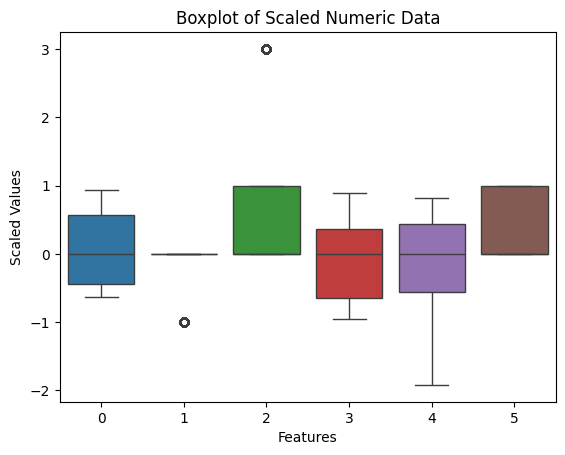

In [251]:

sns.boxplot(data=scaled_numeric)
plt.title('Boxplot of Scaled Numeric Data')
plt.xlabel('Features')
plt.ylabel('Scaled Values')
plt.show()

In [252]:
# We set contamination very low so we only get the most extreme values.
od = KNN(contamination=0.05)
od.fit(scaled_numeric)

outliers = od.predict(scaled_numeric)
outliers

outliers.sum()

df_copy[outliers.astype('bool')]

customerID  tenure  PhoneService  Contract              PaymentMethod  \
40    8865-TNMNX      10             1         1               Mailed check   
116   9560-BBZXK      36             0         3  Bank transfer (automatic)   
131   6207-WIOLX      25             0         0    Credit card (automatic)   
132   8587-XYZSF      67             1         3  Bank transfer (automatic)   
158   6371-NZYEG      16             1         3               Mailed check   
...          ...     ...           ...       ...                        ...   
6869  5906-CVLHP      45             1         1    Credit card (automatic)   
6926  1450-SKCVI      56             1         0           Electronic check   
6975  1904-WAJAA      24             1         3           Electronic check   
7021  1699-HPSBG      12             1         1           Electronic check   
7036  7750-EYXWZ      12             0         1           Electronic check   

      MonthlyCharges  TotalCharges  Churn  
40             49.55      6.164787      0  
116            31.05      7.026738      0  
131            58.60      7.314985      1  
132            50.55      8.089513      0  
158            64.25      6.931472      0  
...              ...           ...    ...  
6869           54.15      7.749236      1  
6926           73.85      8.316997      1  
6975           64.35      7.351575      0  
7021           59.80      6.590026      1  
7036           60.65      6.611100      0  

[276 rows x 8 columns]

## Fill missing values with ML

In [253]:
df_missing = numeric_df.copy()
df_missing.loc[df['TotalCharges'] == 100, 'TotalCharges'] = np.nan
df_missing.tail()

tenure  PhoneService  Contract  MonthlyCharges  TotalCharges  Churn
7038      24             1         1           84.80      7.596141      0
7039      72             1         1          103.20      8.904209      0
7040      11             0         0           29.60      5.847739      0
7041       4             1         0           74.40      5.725544      1
7042      66             1         3          105.65      8.831201      0

In [254]:
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   PhoneService    7043 non-null   int64  
 2   Contract        7043 non-null   int64  
 3   MonthlyCharges  7043 non-null   float64
 4   TotalCharges    7043 non-null   float64
 5   Churn           7043 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 330.3 KB


In [255]:
df_missing.isna().sum()

tenure            0
PhoneService      0
Contract          0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

In [258]:

numeric_columns = df_copy.select_dtypes(include=np.number).columns

# SimpleImputer instance
imputer = SimpleImputer(strategy='median')

# Fit and transform the imputer on the numeric columns
filled_values = imputer.fit_transform(df[numeric_columns])

filled_values


array([[1.0000e+00, 0.0000e+00, 0.0000e+00, 2.9850e+01, 2.9850e+01,
        0.0000e+00],
       [3.4000e+01, 1.0000e+00, 1.0000e+00, 5.6950e+01, 1.8895e+03,
        0.0000e+00],
       [2.0000e+00, 1.0000e+00, 0.0000e+00, 5.3850e+01, 1.0815e+02,
        1.0000e+00],
       ...,
       [1.1000e+01, 0.0000e+00, 0.0000e+00, 2.9600e+01, 3.4645e+02,
        0.0000e+00],
       [4.0000e+00, 1.0000e+00, 0.0000e+00, 7.4400e+01, 3.0660e+02,
        1.0000e+00],
       [6.6000e+01, 1.0000e+00, 3.0000e+00, 1.0565e+02, 6.8445e+03,
        0.0000e+00]])

In [259]:
# Convert the filled values back to a DataFrame
filled_df = pd.DataFrame(data=filled_values, columns=numeric_columns, index=df.index)

filled_df



tenure  PhoneService  Contract  MonthlyCharges  TotalCharges  Churn
0        1.0           0.0       0.0           29.85         29.85    0.0
1       34.0           1.0       1.0           56.95       1889.50    0.0
2        2.0           1.0       0.0           53.85        108.15    1.0
3       45.0           0.0       1.0           42.30       1840.75    0.0
4        2.0           1.0       0.0           70.70        151.65    1.0
...      ...           ...       ...             ...           ...    ...
7038    24.0           1.0       1.0           84.80       1990.50    0.0
7039    72.0           1.0       1.0          103.20       7362.90    0.0
7040    11.0           0.0       0.0           29.60        346.45    0.0
7041     4.0           1.0       0.0           74.40        306.60    1.0
7042    66.0           1.0       3.0          105.65       6844.50    0.0

[7043 rows x 6 columns]

In [260]:
# Combine filled numeric columns with object columns
full_df = pd.concat([filled_df, df.select_dtypes(include=['object'])], axis=1)

full_df.head()

tenure  PhoneService  Contract  MonthlyCharges  TotalCharges  Churn  \
0     1.0           0.0       0.0           29.85         29.85    0.0   
1    34.0           1.0       1.0           56.95       1889.50    0.0   
2     2.0           1.0       0.0           53.85        108.15    1.0   
3    45.0           0.0       1.0           42.30       1840.75    0.0   
4     2.0           1.0       0.0           70.70        151.65    1.0   

               PaymentMethod  
0           Electronic check  
1               Mailed check  
2               Mailed check  
3  Bank transfer (automatic)  
4           Electronic check

In [261]:
full_df.isna().sum()

tenure            0
PhoneService      0
Contract          0
MonthlyCharges    0
TotalCharges      0
Churn             0
PaymentMethod     0
dtype: int64

In [265]:
full_df['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

## One-hot encoding for multi-category variables

In [266]:
pd.get_dummies(df['PaymentMethod'])

Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
0                         False                    False              True   
1                         False                    False             False   
2                         False                    False             False   
3                          True                    False             False   
4                         False                    False              True   
...                         ...                      ...               ...   
7038                      False                    False             False   
7039                      False                     True             False   
7040                      False                    False              True   
7041                      False                    False             False   
7042                       True                    False             False   

      Mailed check  
0            False  
1             True  
2             True  
3            False  
4            False  
...            ...  
7038          True  
7039         False  
7040         False  
7041          True  
7042         False  

[7043 rows x 4 columns]

In [269]:

one_hot_df = pd.get_dummies(df['PaymentMethod'])

# Drop the last column
one_hot_df = one_hot_df.iloc[:, :-1]

one_hot_df


Bank transfer (automatic)  Credit card (automatic)  Electronic check
0                         False                    False              True
1                         False                    False             False
2                         False                    False             False
3                          True                    False             False
4                         False                    False              True
...                         ...                      ...               ...
7038                      False                    False             False
7039                      False                     True             False
7040                      False                    False              True
7041                      False                    False             False
7042                       True                    False             False

[7043 rows x 3 columns]

In [273]:
# Combine the one-hot encoded columns with the original DataFrame
concat_df = pd.concat([df, one_hot_df], axis=1)

concat_df

customerID  tenure  PhoneService  Contract  MonthlyCharges  \
0              1       1             0         0           29.85   
1              2      34             1         1           56.95   
2              3       2             1         0           53.85   
3              4      45             0         1           42.30   
4              5       2             1         0           70.70   
...          ...     ...           ...       ...             ...   
7038        7039      24             1         1           84.80   
7039        7040      72             1         1          103.20   
7040        7041      11             0         0           29.60   
7041        7042       4             1         0           74.40   
7042        7043      66             1         3          105.65   

      TotalCharges  Churn  MonthlyCharges_to_tenure_Ratio  \
0            29.85      0                       29.850000   
1          1889.50      0                        1.675000   
2           108.15      1                       26.925000   
3          1840.75      0                        0.940000   
4           151.65      1                       35.350000   
...            ...    ...                             ...   
7038       1990.50      0                        3.533333   
7039       7362.90      0                        1.433333   
7040        346.45      0                        2.690909   
7041        306.60      1                       18.600000   
7042       6844.50      0                        1.600758   

      Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
0                         False                    False              True   
1                         False                    False             False   
2                         False                    False             False   
3                          True                    False             False   
4                         False                    False              True   
...                         ...                      ...               ...   
7038                      False                    False             False   
7039                      False                     True             False   
7040                      False                    False              True   
7041                      False                    False             False   
7042                       True                    False             False   

      Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
0                         False                    False              True   
1                         False                    False             False   
2                         False                    False             False   
3                          True                    False             False   
4                         False                    False              True   
...                         ...                      ...               ...   
7038                      False                    False             False   
7039                      False                     True             False   
7040                      False                    False              True   
7041                      False                    False             False   
7042                       True                    False             False   

      Bank transfer (automatic)  Credit card (automatic)  Electronic check  \
0                         False                    False              True   
1                         False                    False             False   
2                         False                    False             False   
3                          True                    False             False   
4                         False                    False              True   
...                         ...                      ...               ...   
7038                      False     

## Logarithmic transformation

<Figure size 1000x500 with 0 Axes>

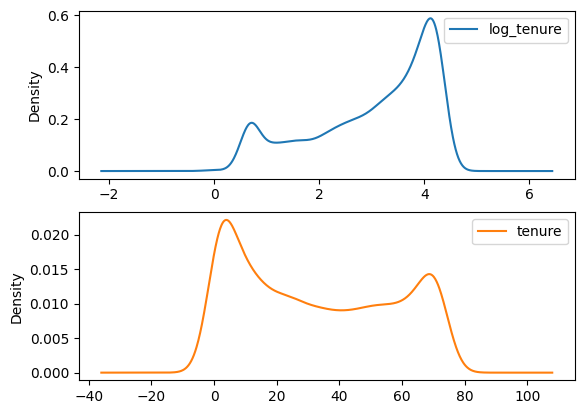

In [274]:
df['log_tenure'] = np.log1p(df['tenure']) 

# Plot the density of the transformed column and the original tenure column
plt.figure(figsize=(10, 5))
df[['log_tenure', 'tenure']].plot.density(subplots=True, sharex=False)
plt.show()

# Analysis and Explanation

## Value Counts for Churn

The value counts for the Churn column are imporatnt and help in understanding the distribution of customers based on their churn status.
There are 5174 customers who did not churn (Churn: No) and 1869 customers who churned (Churn: Yes). This information provides a baseline understanding of the dataset's churn distribution, which is essential for subsequent analyses related to customer retention and predictive modeling.

## Filtering Data

Data is filtered based on the Contract column, Churn column specifically the unique No values  and highly monthly charges in the MonthlyCharges Column
```shell
unique_churn_values: Contains data for customers who did not churn
high_monthly_charges_df: Contains data for customers with monthly rates greater than 80.
```
This enables a focused analysis on specific segments of the customer base, such as those who have churned or those with longer tenure.

## Violin for Numeric Columns

The violin plot visually represents the distribution of numeric columns (tenure, MonthlyCharges, and TotalCharges).
Identifying potential outliers is essential for understanding data quality and potential data issues. The boxplot aids in visualizing the spread of data and potential extreme values.

## Handling Outliers

Outliers are clipped for each numeric column using the interquartile range (IQR) method.
Outliers can significantly impact statistical analyses. By handling outliers, the dataset becomes more robust, and subsequent analyses are less influenced by extreme values.

## Missing Values Check and Handling

There are 11 missing values in the TotalCharges column.
Missing values are dropped using df.dropna(inplace=True).


## Categorical to Numeric Conversion

The Contract, Churn and PhoneService columns are converted to numeric. Converting categorical variables to numeric is necessary for many machine learning algorithms. It facilitates quantitative analysis and model training.

## Feature Engineering

Log transformation of MonthlyCharges and the creation of a new feature:
```shell
MonthlyCharges_to_tenure_Ratio (Ratio of MonthlyCharges to Tenure)

```
Feature engineering helps create additional relevant features that may improve the performance of predictive models. Log transformation is often used to handle skewed data, and the new ratios provide insights into the relationships between variables.


## Advanced Outlier Detection - Boxplot Analysis

The boxplot for scaled numeric data, as part of advanced outlier detection, provides insights into the distribution of standardized values for different features. 
**Tenure**
The boxplot shows that most values are clustered around the median, with a few outliers at both ends. This suggests that while the majority of customers have similar tenure values, there are some extreme cases.

**PhoneService**

Being a binary variable (0 or 1), the boxplot here indicates that the values are concentrated at the extremes (0 and 1), with no apparent outliers.

**MonthlyCharges**

The boxplot for MonthlyCharges shows a relatively symmetric distribution with a few outliers on the higher side. This suggests that most customers have similar monthly charges, but there are some with significantly higher charges.

**TotalCharges**

Similar to MonthlyCharges, TotalCharges exhibit a symmetric distribution with a few outliers on the higher side. This implies that while most customers have similar total charges, there are outliers with exceptionally high total charges.

**Churn**

Being a binary variable (0 or 1), the boxplot for Churn indicates that the values are concentrated at the extremes (0 and 1), with no apparent outliers.

**MonthlyCharges_to_TotalCharges_Ratio**

The boxplot reveals a distribution of the ratio, showing the spread and presence of outliers. Most values are clustered around the median, but there are some customers with significantly different ratios, indicating potential variations in spending patterns.


## Merged DataFrames

The merged DataFrame combines the imputed tenure values with the original DataFrame, resulting in a dataset with non-null tenure values.


## Logarithmic Transform

This transform is applied to the tenure column. The transformed data is centered around 0 and standardized, making the distribution more symmetric and normal. The density plot shows the before-and-after comparison, highlighting the transformation's impact on the distribution.

# Summary

A comprehensive analysis of a customer churn dataset was analysed. The initial exploration involves examining the distribution of the target variable, *Churn*, revealing that 5174 customers did not churn, while 1869 customers did. Data is then filtered into two distinct DataFrames, *churn_df* and *long_tenure_df*, focusing on churned customers and those with tenure greater than 50, respectively. A violin plot is generated to visualize the distribution of numeric columns, highlighting potential outliers. The subsequent handling of outliers involves clipping values based on the interquartile range. Missing values in the *TotalCharges* column are identified and addressed by dropping corresponding entries. Categorical-to-numeric conversion is performed for the *Churn* and *PhoneService* columns. Feature engineering includes log transformation of *MonthlyCharges* and the creation of a new feature *MonthlyCharges_to_tenure_Ratio.*

We conclude with scatter plots and histograms and a logarithmic transformation offering visual insights into feature relationships.